In [2]:
import pandas as pd

#Data Visualization
df = pd.read_csv("Health_Risk_Dataset.csv")
print(df.info())
print(df['Risk_Level'].value_counts())
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         1000 non-null   object 
 1   Respiratory_Rate   1000 non-null   int64  
 2   Oxygen_Saturation  1000 non-null   int64  
 3   O2_Scale           1000 non-null   int64  
 4   Systolic_BP        1000 non-null   int64  
 5   Heart_Rate         1000 non-null   int64  
 6   Temperature        1000 non-null   float64
 7   Consciousness      1000 non-null   object 
 8   On_Oxygen          1000 non-null   int64  
 9   Risk_Level         1000 non-null   object 
dtypes: float64(1), int64(6), object(3)
memory usage: 78.3+ KB
None
Risk_Level
Medium    306
High      279
Low       255
Normal    160
Name: count, dtype: int64


Patient_ID           0
Respiratory_Rate     0
Oxygen_Saturation    0
O2_Scale             0
Systolic_BP          0
Heart_Rate           0
Temperature          0
Consciousness        0
On_Oxygen            0
Risk_Level           0
dtype: int64

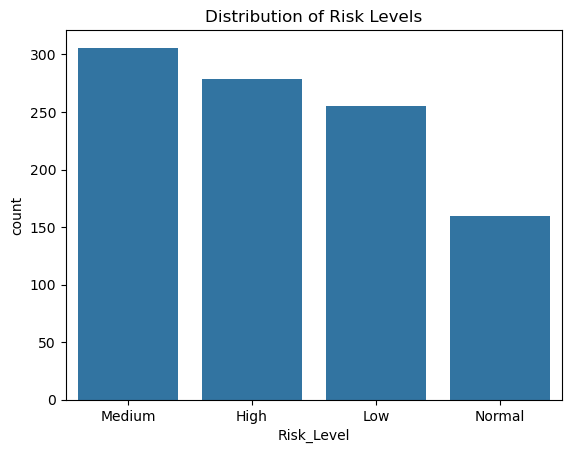

In [4]:
#Class Distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Risk_Level", data=df)
plt.title("Distribution of Risk Levels")
plt.show()

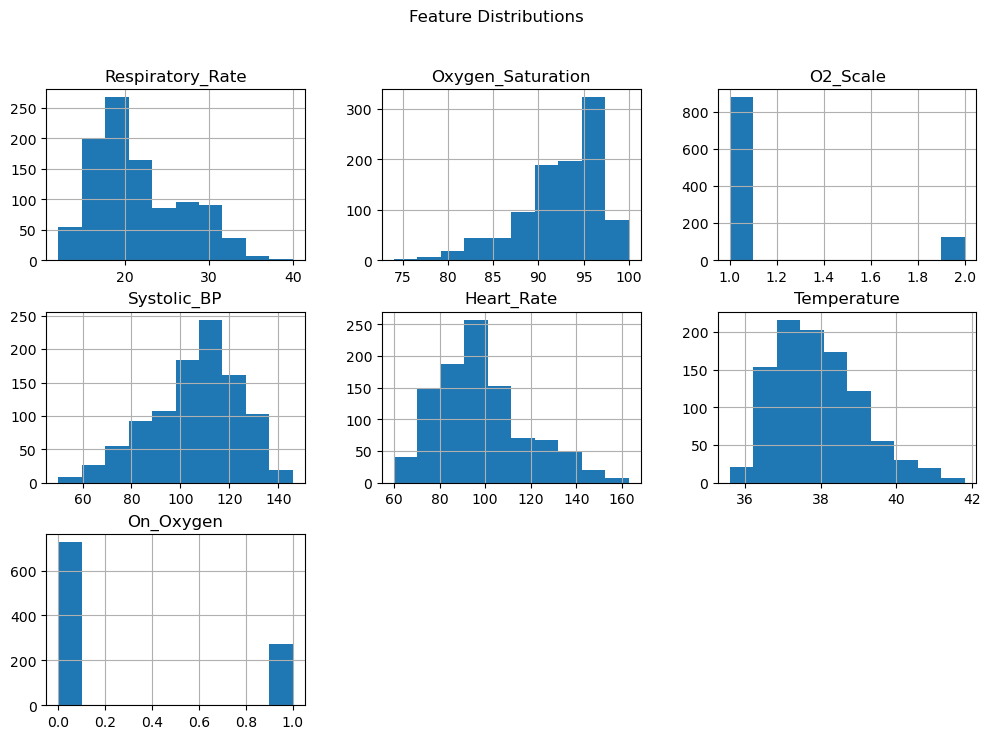

In [5]:
#Histograms / KDE (Feature Distributions)
df.hist(figsize=(12,8))
plt.suptitle("Feature Distributions")
plt.show()


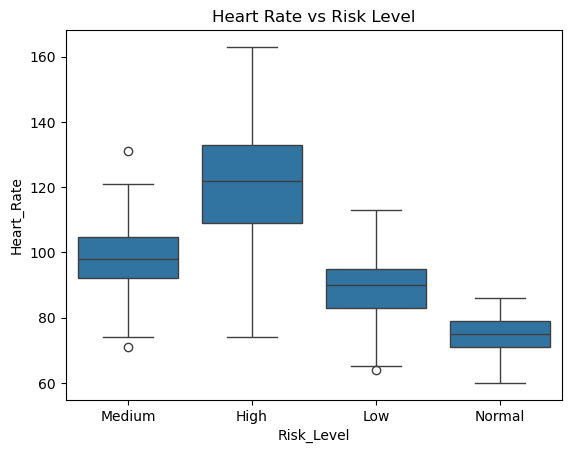

In [6]:
#Boxplots by Risk Level
sns.boxplot(x="Risk_Level", y="Heart_Rate", data=df)
plt.title("Heart Rate vs Risk Level")
plt.show()


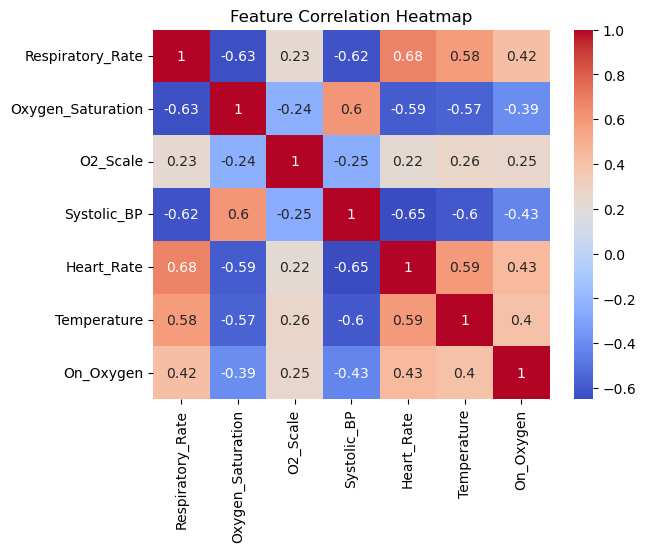

In [9]:
#Correlation Heatmap
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

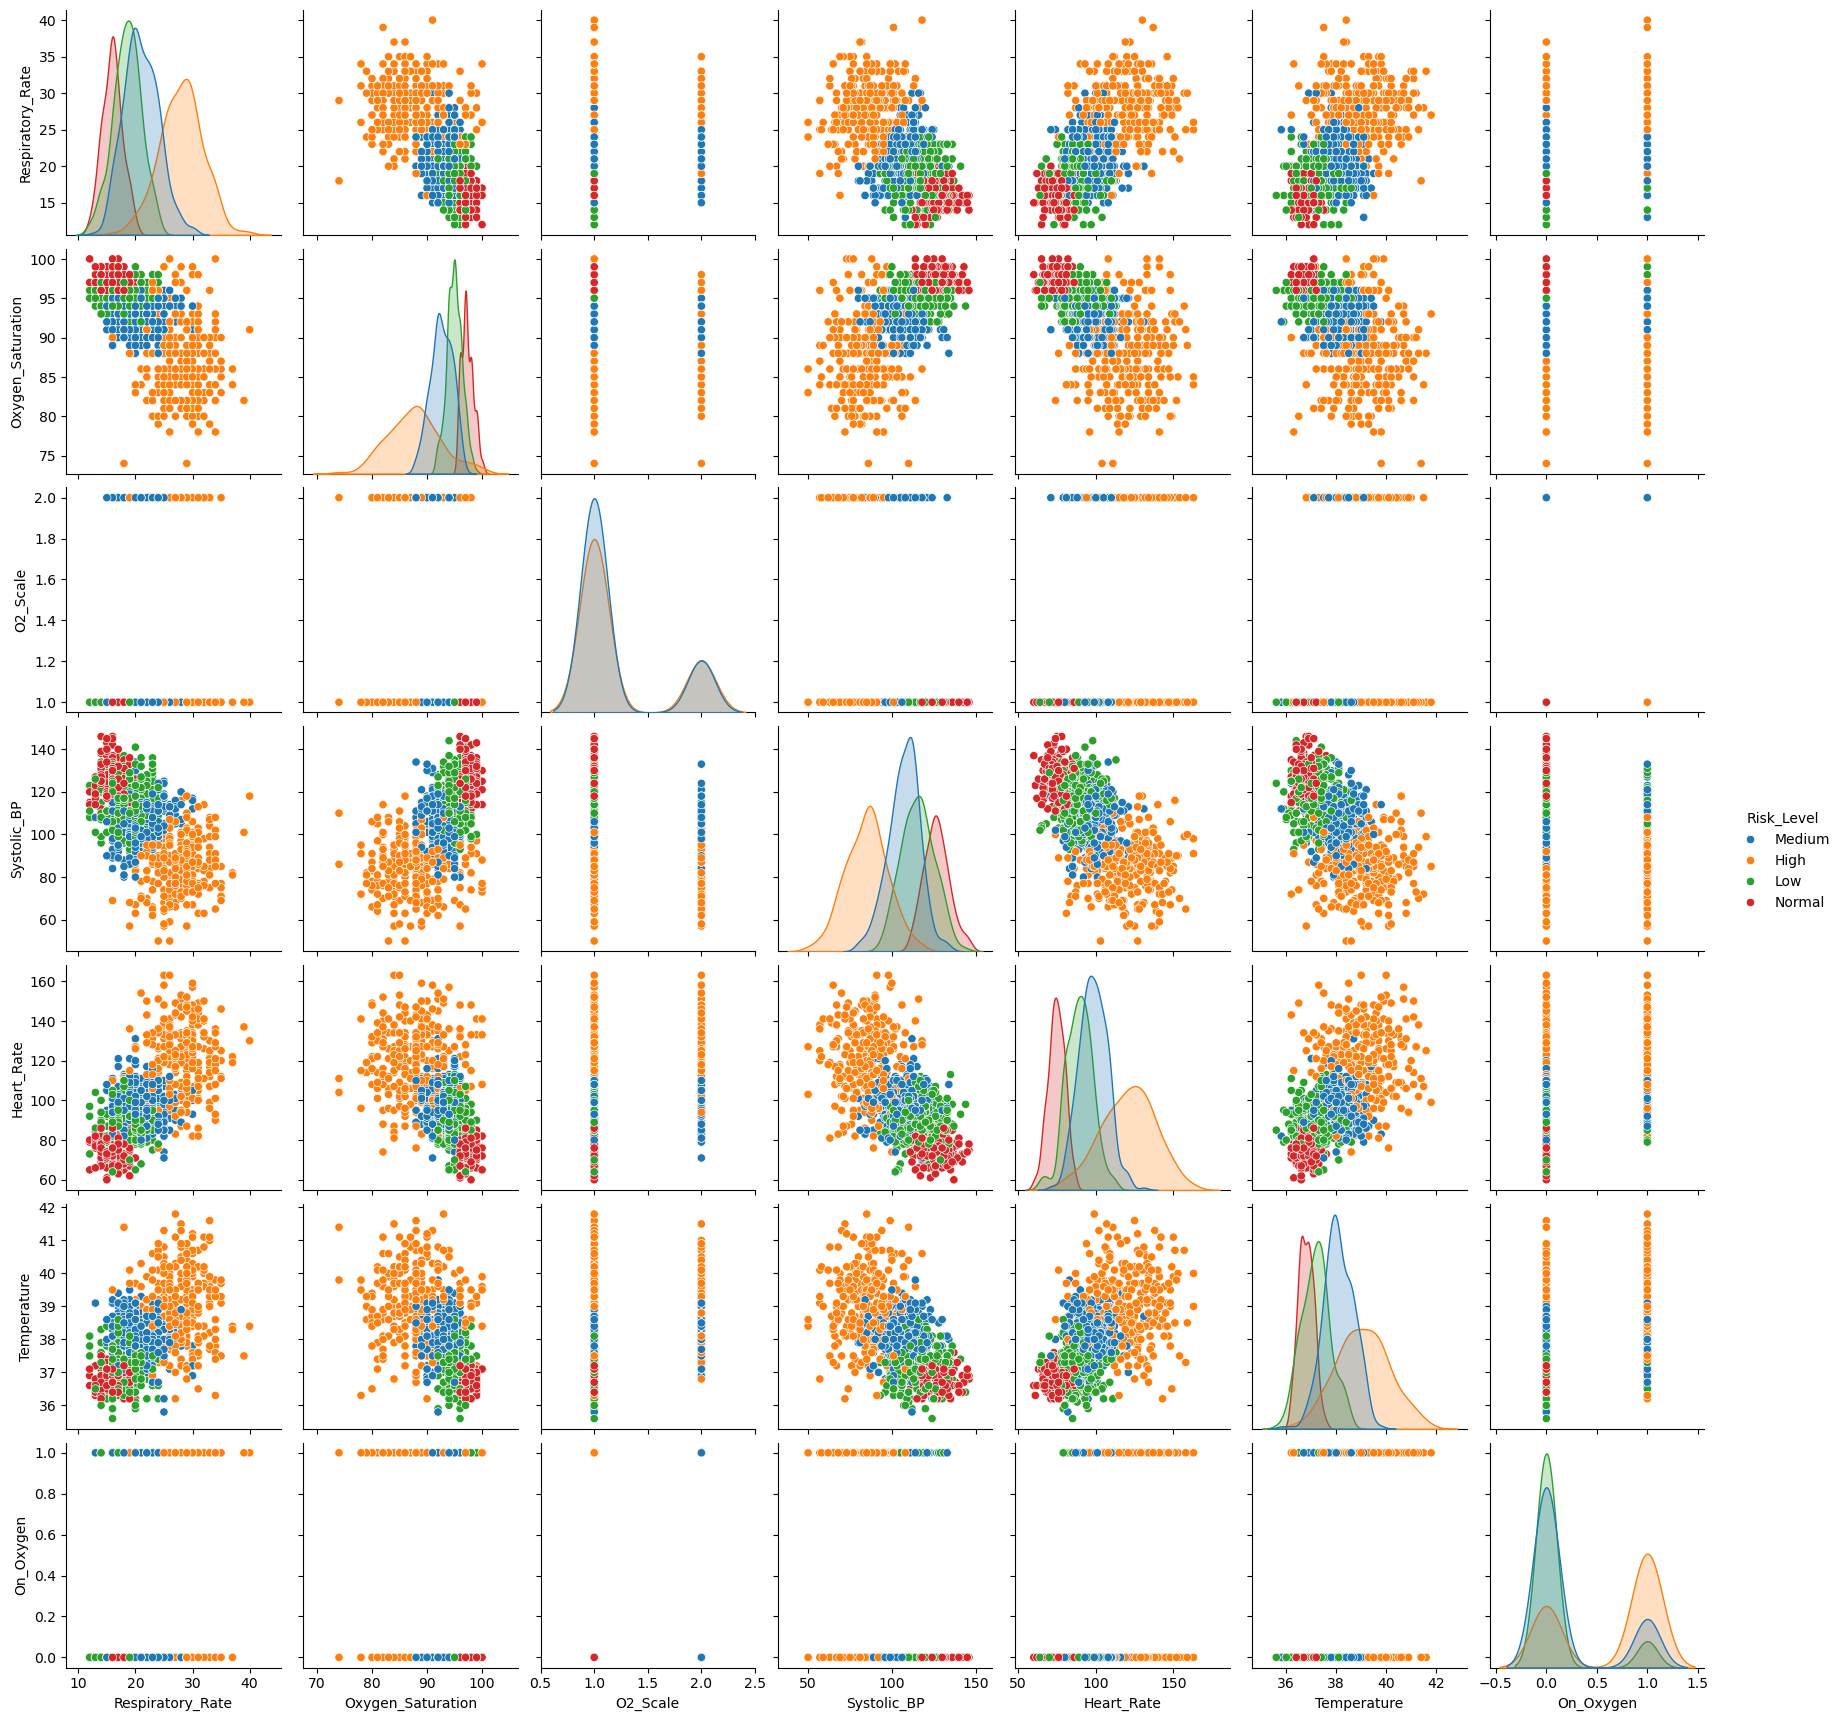

In [12]:
sns.pairplot(df.drop(columns=['Patient_ID']), hue='Risk_Level')
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df.drop(['Patient_ID','Risk_Level'], axis=1)
y = LabelEncoder().fit_transform(df['Risk_Level'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = ['Respiratory_Rate','Oxygen_Saturation','O2_Scale',
                    'Systolic_BP','Heart_Rate','Temperature','On_Oxygen']
categorical_features = ['Consciousness']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

In [19]:
from sklearn.pipeline import Pipeline

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('pre', preprocessor),
        ('clf', model)
    ])


In [22]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
    print(classification_report(y_test, y_pred))
#Train and Evaluate


=== LogisticRegression ===
Accuracy: 0.96
F1 Score (macro): 0.9608701782088879
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        56
           1       0.92      0.96      0.94        51
           2       0.94      0.97      0.95        61
           3       1.00      0.94      0.97        32

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200


=== DecisionTree ===
Accuracy: 0.91
F1 Score (macro): 0.9199169674265613
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        56
           1       0.84      0.90      0.87        51
           2       0.88      0.82      0.85        61
           3       1.00      1.00      1.00        32

    accuracy                           0.91       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.91      0.

C:\Users\ayona\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:43:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


C:\Users\ayona\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [06:43:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                    Accuracy  Precision    Recall  F1 Score
LogisticRegression     0.960   0.965259  0.957446  0.960870
DecisionTree           0.910   0.919461  0.921480  0.919917
RandomForest           0.950   0.959950  0.949749  0.953636
KNN                    0.975   0.974508  0.974259  0.974263
XGBoost                0.965   0.969778  0.965258  0.967374


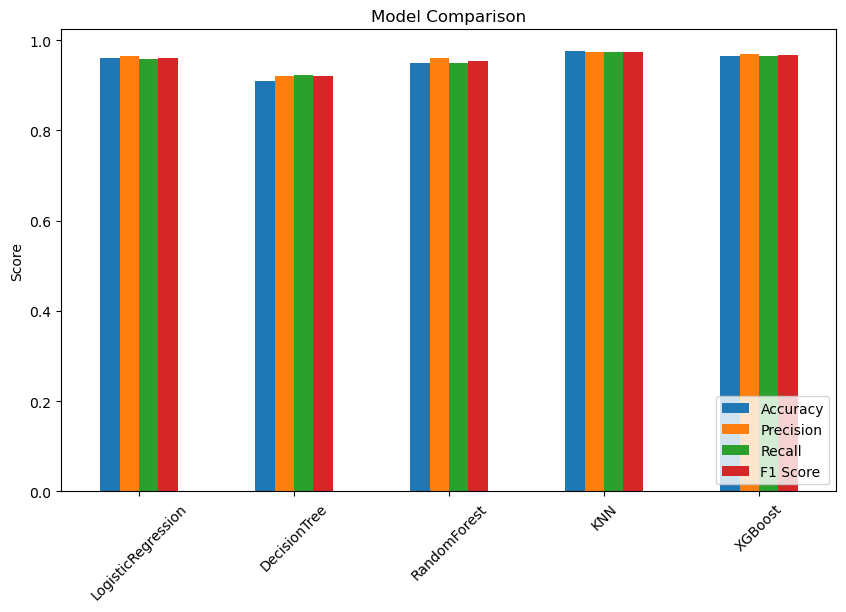

In [24]:
from sklearn.metrics import precision_score, recall_score

results = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average="macro")
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

# Convert to DataFrame for comparison
results_df = pd.DataFrame(results).T
print(results_df)

# Optional: plot bar chart for comparison
results_df.plot(kind="bar", figsize=(10,6))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()


In [26]:
# Suppose your results_df is the comparison DataFrame
metric = "F1 Score" 

best_model_name = results_df[metric].idxmax()
best_model_score = results_df[metric].max()

print(f"Best Model: {best_model_name}")
print(f"{metric}: {best_model_score:.4f}")


Best Model: KNN
F1 Score: 0.9743


In [32]:
best_model = pipelines[best_model_name]

# Fit it (if not already fitted)
best_model.fit(X_train, y_train)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Respiratory_Rate',
                                                   'Oxygen_Saturation',
                                                   'O2_Scale', 'Systolic_BP',
                                                   'Heart_Rate', 'Temperature',
                                                   'On_Oxygen']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Consciousness'])])),
                ('clf', KNeighborsClassifier())])

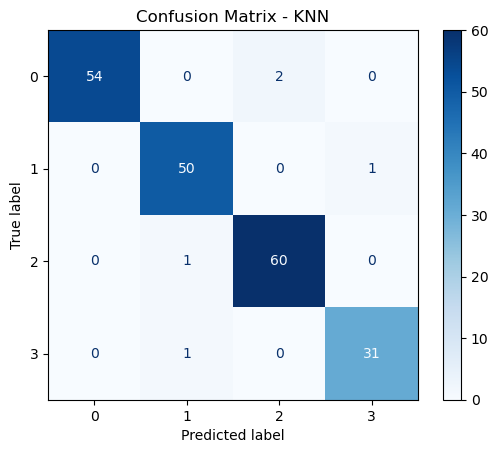

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions with best model
y_pred_best = best_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


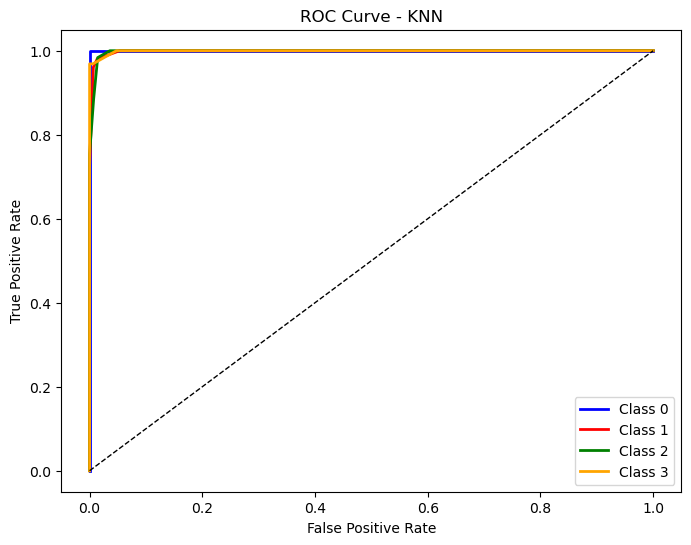

In [36]:
from sklearn.metrics import RocCurveDisplay

if len(best_model.classes_) == 2:
    # Binary classification ROC
    y_proba = best_model.predict_proba(X_test)[:,1]
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve - {best_model_name}")
    plt.show()
else:
    # Multiclass ROC (one-vs-rest)
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    from itertools import cycle

    y_bin = label_binarize(y_test, classes=best_model.classes_)
    y_proba = best_model.predict_proba(X_test)

    plt.figure(figsize=(8,6))
    colors = cycle(["blue", "red", "green", "orange", "purple"])
    for i, color in zip(range(len(best_model.classes_)), colors):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, color=color, lw=2, label=f"Class {best_model.classes_[i]}")

    plt.plot([0,1], [0,1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {best_model_name}")
    plt.legend()
    plt.show()
